In [1]:
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import transforms
import numpy as np
import random
from matplotlib import pyplot as plt
from tqdm.auto import tqdm
from skimage.metrics import structural_similarity as ssim
from PIL import Image

In [2]:
from facedataset import FaceDataset
from metrics import psnr
from layers import GaussianBlur

In [3]:
from model import Model
from classic_model import Classic

In [4]:
def reset_seeds():
    random.seed(714)
    np.random.seed(714)
    torch.manual_seed(714)

reset_seeds()
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

In [5]:
batch_size = 4 # must be divisble by 2
input_size = 64
upscaling_factor = 4
output_size = upscaling_factor*input_size
use_gpu = torch.cuda.is_available()

num_examples = 4 # number of examples printed

In [6]:
def load_model(name, upscaling_factor=2):
    model = Model(upscaling_factor)
    model.load_state_dict(torch.load(f"weights/{name}.ckpt", map_location=torch.device('cpu')))
    if use_gpu:
        model = model.cuda()
    
    return model

In [10]:
name = "model_crit_mse_reg_none_64"
short_name = "mse"
model = load_model(name, 4)
# model = Classic(output_size)
model.eval()
gb = GaussianBlur(3, 1.0)

## FFHQ

In [14]:
data_path = "data/small256x256"
test_set = FaceDataset(data_path, 65000, 70000, input_size, upscaling_factor, p_flip=0)
test_loader = DataLoader(test_set, batch_size = batch_size, shuffle=False, num_workers=4)

In [8]:
data_path = "data/comp_test"
test_set = FaceDataset(data_path, 0, 100, input_size, upscaling_factor, p_flip=0)
test_loader = DataLoader(test_set, batch_size = batch_size, shuffle=False, num_workers=4)

In [38]:
class MultiModel(nn.Module):
    def __init__(self, model, amount):
        super(MultiModel, self).__init__()
        
        self.model = model
        self.amount = amount
        self.gb = GaussianBlur(3, 1.0, use_gpu)
    
    def forward(self, x):
        out = x
        for i in range(self.amount-1):
            out = self.model(out)
            out = self.gb(out)
        out = self.model(out)
        
        return out

In [68]:
multi = MultiModel(model, 3)

In [16]:
def eval_model(model):
    model.eval()

    with torch.no_grad():
        val_psnr = []
        val_ssim = []

        for img, target in tqdm(test_loader):
            if use_gpu:
                img = img.cuda()
                target = target.cuda()
            out = model(img)
            val_psnr.append(psnr(out, target))
            out = out.cpu().permute(0, 2, 3, 1).numpy()
            target = target.cpu().permute(0, 2, 3, 1).numpy()
            for i in range(out.shape[0]):
                val_ssim.append(ssim(out[i], target[i], data_range=1, multichannel=True))


        val_psnr = torch.cat(val_psnr)
        val_ssim = torch.tensor(val_ssim)

    print(f"Mean PSNR {torch.mean(val_psnr):.2f} ± {torch.std(val_psnr):.2f}")
    print(f"Mean SSIM {torch.mean(val_ssim):.3f} ± {torch.std(val_ssim):.2f}")

In [17]:
eval_model(model)


Mean PSNR 27.91 ± 2.29
Mean SSIM 0.820 ± 0.05


In [11]:
with torch.no_grad():
    for k, (img, target) in tqdm(enumerate(test_loader), total=len(test_loader)):
        out = torch.clamp(model(img), 0, 1)
        psnrs = psnr(out, target)
        for i in range(batch_size):
            out_np = out[i].permute(1,2,0).numpy()
            target_np = target[i].permute(1,2,0).numpy()
            ssim_img = ssim(out_np, target_np, data_range=1, multichannel=True)
            img_pil = transforms.functional.to_pil_image(img[i])
            img_pil.save(f"results/{upscaling_factor}x/low_{k*batch_size+i}.png")
            target_pil = transforms.functional.to_pil_image(target[i])
            target_pil.save(f"results/{upscaling_factor}x/high_{k*batch_size+i}.png")
            out_pil = transforms.functional.to_pil_image(out[i])
            out_pil.save(f"results/{upscaling_factor}x/{short_name}_{k*batch_size+i}.png")
            with open(f"results/{upscaling_factor}x/{short_name}_{k*batch_size+i}.tex", "w") as file:
                file.write(rf"PSNR: {psnrs[i]:.2f}\\" + f"\nSSIM: {ssim_img:.3f}")

In [13]:
b1 = [(x*upscaling_factor)//2 for x in (35, 45, 55, 65)]
b2 = [(x*upscaling_factor)//2 for x in (30, 80, 50, 100)]
for fn in [short_name, "low", "high"]:
    img = Image.open(f"results/{upscaling_factor}x/{fn}_29.png").resize((upscaling_factor*input_size, upscaling_factor*input_size))
    img.crop(b1).save(f"results/{upscaling_factor}x/crops/{fn}1_29.png")
    img.crop(b2).save(f"results/{upscaling_factor}x/crops/{fn}2_29.png")

# Set 5 & 14

In [8]:
import os

In [23]:
os.chdir("data")

In [24]:
os.chdir("Set5")

In [11]:
os.listdir()

['baby.png', 'bird.png', 'butterfly.png', 'head.png', 'woman.png']

In [28]:
with torch.no_grad():
    val_psnr = []
    val_ssim = []

    for fn in os.listdir():
        target = transforms.functional.to_tensor(Image.open(fn)).unsqueeze(0)
        if fn == "comic.png" or fn=="zebra.png":
            target = target[:,:,:-1,:]
        if fn == "ppt3.png":
            target = target[:,:,:,:-1]
        img = gb(target)[:,:,::2,::2]

        if use_gpu:
            img = img.cuda()
            target = target.cuda()
        #out = model(img)
        out = transforms.functional.to_pil_image(img.squeeze())
        out = out.resize((out.size[0]*2, out.size[1]*2), 3)
        out = transforms.functional.to_tensor(out).unsqueeze(0)
        val_psnr.append(psnr(out, target))
        out = out.cpu().permute(0, 2, 3, 1).numpy()
        target = target.cpu().permute(0, 2, 3, 1).numpy()
        for i in range(out.shape[0]):
            val_ssim.append(ssim(out[i], target[i], data_range=1, multichannel=True))


    val_psnr = torch.cat(val_psnr)
    val_ssim = torch.tensor(val_ssim)

    print(f"Mean PSNR {torch.mean(val_psnr):.2f} ± {torch.std(val_psnr):.2f}")
    print(f"Mean SSIM {torch.mean(val_ssim):.3f} ± {torch.std(val_ssim):.2f}")

Mean PSNR 25.23 ± 2.56
Mean SSIM 0.777 ± 0.10


In [ ]:
print(val_psnr)

In [27]:
os.chdir("../Set14")

In [13]:
del target

# Drawn

In [20]:
img = Image.open("results/Bild/ausgang.png").convert("RGB").resize((256, 256), 3)

In [21]:
img.size

(256, 256)

In [20]:
out = gb(transforms.functional.to_tensor(img).unsqueeze(0))[:,:,::4,::4]

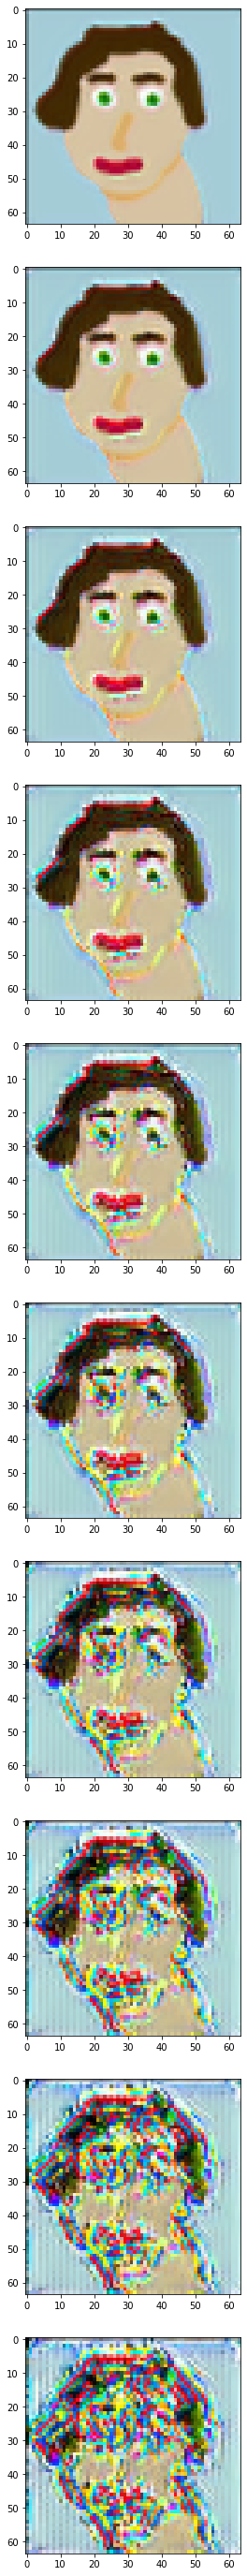

In [21]:
fig, ax = plt.subplots(10)
with torch.no_grad():
    for i in tqdm(range(10)):
        for j in range(10):
            out = model(out)
            out = torch.clamp(out, 0, 1)
            out = gb(out)
            out = out[:, :, ::4, ::4]
        ax[i].imshow(out.squeeze().permute(1,2,0))

fig.set_size_inches(5, 50)
plt.show()